#### Імпорт необхідних бібліотек

In [1]:
import os
import re
import json
import requests

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from pprint import pprint
from collections import Counter
from typing import List, Dict, Set, Tuple
from dotenv import load_dotenv
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

#### Функція для отримання даних з Jooble (агрегатора вакансій) та збереження даних в JSON

In [2]:
def get_jooble_jobs(keyword: str, location: str, page_limit: int = 5) -> List[Dict[str, str]]:
    url = "https://jooble.org/api/"
    api_key = os.getenv("API_KEY")
    headers = {"Content-Type": "application/json"}

    payload = {
        "keywords": keyword,
        "location": location,
        "page": 1,
    }

    jobs = []
    for page in range(1, page_limit + 1):
        payload["page"] = page
        response = requests.post(url + api_key, headers=headers, json=payload)

        if response.status_code == 200:
            body = response.json()
    
            for job in body.get("jobs", []):
                jobs.append({
                    "title": job.get("title"),
                    "company": job.get("company"),
                    "location":job.get("location"),
                    "description": job.get("snippet"),
                    "date_posted": job.get("updated"),
                })
        else:
            print(f"Error: {response.status_code}, {response.text}")

    return jobs

load_dotenv()
jobs_list = get_jooble_jobs(keyword="Python", location="USA", page_limit=100)

with open("jobs.json", "w", encoding="utf-8") as file:
    json.dump(jobs_list, file, indent=4)

#### Формат вхідних даних (збережений JSON документ)

In [3]:
!head -n 29 jobs.json

[
    {
        "title": "Lead Software Engineer - Scraping",
        "company": "Next Ventures Ltd",
        "location": "New York, NY",
        "description": "&nbsp;...development, and maintence of scalable scraping solutions as part of their data technology team. The ideal candidate is an expert <b>Python </b>developer with strong experience in web scraping and related technologies.  \r\n  Responsibilities  \r\n \r\n Provide effective technical...&nbsp;",
        "date_posted": "2024-12-12T00:00:00.0000000"
    },
    {
        "title": "Senior Python Developer - Hybrid/ Philadelphia, PA",
        "company": "Two95 International Inc.",
        "location": "Philadelphia, PA",
        "description": "&nbsp;...Title \u2013 Senior <b>Python </b>Developer \r\n  Position \u2013 Fulltime \r\n  Location \u2013 Hybrid/Philadelphia, PA \r\n  Salary - $Open (Best Possible)\r\n~6+ years of Python development experience in an enterprise environment. \r\n\r\n \r\n Hands- on experience programmin

#### Створення DataFrame на основі збереженого JSON документу та вивід загальної інформації

In [4]:
df = pd.read_json("jobs.json")
df["date_posted"] = pd.to_datetime(df["date_posted"].str.replace(r"\+.*", "", regex=True))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        1162 non-null   object        
 1   company      1138 non-null   object        
 2   location     1162 non-null   object        
 3   description  1162 non-null   object        
 4   date_posted  1162 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 45.5+ KB


In [5]:
df.head(10)

title  \
0                  Lead Software Engineer - Scraping   
1  Senior Python Developer - Hybrid/ Philadelphia...   
2                            Senior Python Developer   
3  W2 Role Senior Python Developer Alpharetta GA ...   
4                                SQL Excel Developer   
5                            Senior Python Developer   
6                    Senior Spark & Python Developer   
7                     Remote Senior Python Developer   
8                            Senior Python Developer   
9                            Senior Python Developer   

                           company          location  \
0                Next Ventures Ltd      New York, NY   
1         Two95 International Inc.  Philadelphia, PA   
2         Two95 International Inc.      New York, NY   
3                     Intuites LLC    Alpharetta, GA   
4               Alignity Solutions      New York, NY   
5                Oakridge Staffing      New York, NY   
6                     Mavens Guild        McLean, VA   
7                        Lumenalta            Remote   
8  Global Channel Management, Inc.    Woodbridge, NJ   
9       Bright Vision Technologies       Atlanta, GA   

                                         description  \
0  &nbsp;...development, and maintence of scalabl...   
1  &nbsp;...Title – Senior <b>Python </b>Develope...   
2  &nbsp;...Requirements:  \r\n  \r\n •Bachelor’s...   
3  &nbsp;...Role: Senior <b>Python </b>Developer ...   
4  &nbsp;...Quantitative Developer with experienc...   
5  &nbsp;...technology team from scratch. The tea...   
6  &nbsp;...integration processes to enhance loss...   
7   A career at Lumenalta means the freedom to co...   
8  Senior <b>Python </b>Developer needs 7+ years ...   
9  Bright Vision Technologies has a immediate opp...   

                    date_posted  
0 2024-12-12 00:00:00.000000000  
1 2024-11-15 09:55:26.313000000  
2 2024-11-01 09:35:53.547000000  
3 2024-12-11 00:00:00.000000000  
4 2024-11-21 13:49:52.203000000  
5 2024-02-01 08:03:36.160000000  
6 2024-12-01 00:00:00.000000000  
7 2024-11-24 02:17:59.246697300  
8 2024-12-10 08:08:33.003000000  
9 2024-12-12 00:00:00.000000000

#### Очищення HTML тегів з опису вакансій та попередня обробка тексту (видалення стоп-слів та небажаних символів, токенізація)

In [6]:
def clean_html(raw_html: str) -> str:
    cleantext = BeautifulSoup(raw_html, "html.parser").text
    cleantext = re.sub("[\r\n\x0b\x0c]+", " ", cleantext).strip()
    return cleantext

df["description"] = df["description"].apply(clean_html)

def preprocess_text(text: str, stop_words: Set[str]) -> str:
    text = re.sub(r"[^a-zA-Z\s]", "", text, flags=re.IGNORECASE).lower().strip()
    tokens = wordpunct_tokenize(text)
    filtered_tokens = [t for t in tokens if t not in stop_words]
    return " ".join(filtered_tokens)

stop_words = set(stopwords.words("english"))
df["description_cleaned"] = df["description"].apply(lambda text: preprocess_text(text, stop_words))

pprint(df["description_cleaned"][:5].to_list())

['development maintence scalable scraping solutions part data technology team '
 'ideal candidate expert python developer strong experience web scraping '
 'related technologies responsibilities provide effective technical',
 'title senior python developer position fulltime location hybridphiladelphia '
 'pa salary open best possible years python development experience enterprise '
 'environment hands experience programming python ability',
 'requirements bachelors degree computer science related field preferred years '
 'professional experience python expertise fundamentals programming pandas '
 'libraries strong sql linux skills strong',
 'role senior python developer location alpharetta ga daysweek office month '
 'contract looking independent candidate w local candidates must send '
 'documentation nameaddress manager notes python flask',
 'quantitative developer experience building factor scores custom equity '
 'baskets advanced mathematics data automation using python sql excel 

#### Аналіз кількості вакансій за компаніями

In [7]:
company_counts = df["company"].value_counts().reset_index()
company_counts.columns = ["company", "vacancy_count"]

company_counts.head(10)

company  vacancy_count
0                           Apple Inc.             53
1                       Selby Jennings             42
2              Amazon.com Services LLC             37
3      Global Channel Management, Inc.             23
4             Two95 International Inc.             17
5                            VDart Inc             16
6  Alldus International Consulting Ltd             16
7                         Purple Drive             14
8                         Tekvivid Inc             13
9                          stanleyreid             13

#### Візуалізація топ-20 компаній за кількістю вакансій

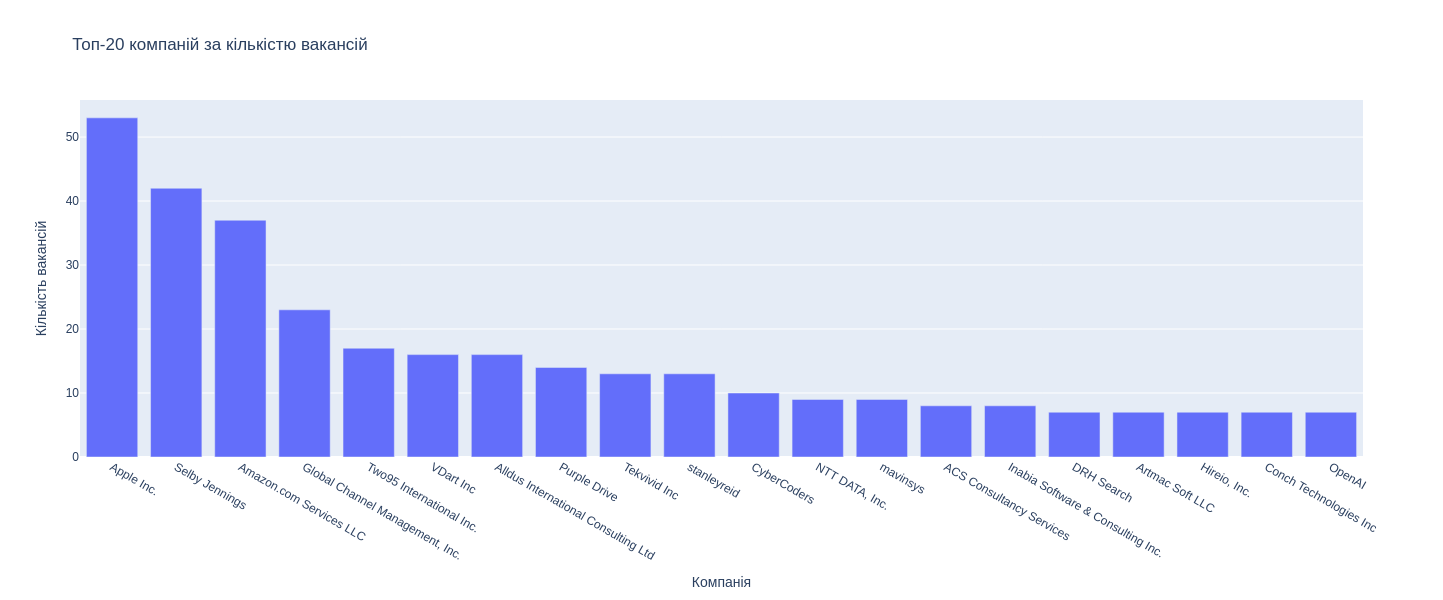

In [8]:
num_of_companies = 20
top_companies = company_counts.head(num_of_companies)

fig = px.bar(
    top_companies, 
    x="company", 
    y="vacancy_count", 
    title=f"Топ-{num_of_companies} компаній за кількістю вакансій",
    labels={"company": "Компанія", "vacancy_count": "Кількість вакансій"},
    width=1200,
    height=600,
)
fig.show()

#### Аналіз кількості вакансій за містами

In [9]:
location_counts = df["location"].value_counts().reset_index()
location_counts.columns = ["location", "vacancy_count"]

location_counts.head(10)

location  vacancy_count
0            New York, NY             98
1                  Remote             91
2              Austin, TX             51
3       San Francisco, CA             38
4             Chicago, IL             37
5  Annapolis Junction, MD             29
6             Seattle, WA             26
7              Dallas, TX             24
8              Boston, MA             22
9               Plano, TX             22

#### Візуалізація топ-20 міст за кількістю вакансій

In [10]:
num_of_locations = 20
top_locations = location_counts.head(num_of_locations)

fig = px.bar(
    top_locations, 
    x="location", 
    y="vacancy_count", 
    title=f"Топ-{num_of_locations} міст за кількістю вакансій",
    labels={"location": "Місто", "vacancy_count": "Кількість вакансій"},
    width=1200,
    height=600,
)
fig.show()

#### Аналіз кількості вакансій по датах

In [11]:
df["date_posted"] = df["date_posted"].dt.date
date_counts = df.groupby("date_posted").size().reset_index(name="vacancy_count")

fig = px.line(
    date_counts, 
    x="date_posted", 
    y="vacancy_count", 
    title="Кількість вакансій по датах",
    labels={"date_posted": "Дата", "vacancy_count": "Кількість вакансій"},
    width=1200,
    height=600,
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

#### Візуалізація розподілу кількості вакансій по топ-20 компаніях та містах у вигляді теплової карти

In [12]:
heatmap_size = 30
top_companies = df["company"].value_counts().head(heatmap_size).index.tolist()
top_locations = df["location"].value_counts().head(heatmap_size).index.tolist()
filtered_df = df[df["company"].isin(top_companies) & df["location"].isin(top_locations)]

pivot_table = pd.pivot_table(
    filtered_df, 
    values="title", 
    index="company", 
    columns="location", 
    aggfunc="count", 
    fill_value=0
)

fig = px.imshow(
    pivot_table,
    title=f"Розподіл кількості вакансій по топ-{heatmap_size} компаніях та містах",
    labels={"x": "Місто", "y": "Компанія", "color": "Кількість вакансій"},
    x=pivot_table.columns,
    y=pivot_table.index,
    color_continuous_scale="Viridis",
    aspect="auto",
    width=1200,
    height=800,
)
fig.show()

#### Альтернативна візуалізація розподілу кількості вакансій по топ-30 компаніях та містах у вигляді OLAP-кубу

In [13]:
x, y, z = pivot_table.columns, pivot_table.index, pivot_table.values

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(
    title="Розподіл кількості вакансій по топ-30 компаніях та містах",
    scene=dict(
        xaxis_title="Місто",
        yaxis_title="Компанія",
        zaxis_title="Кількість вакансій"
    ),
    width=1200,
    height=800
)
fig.show()

#### Створення хмари слів на основі описів вакансій

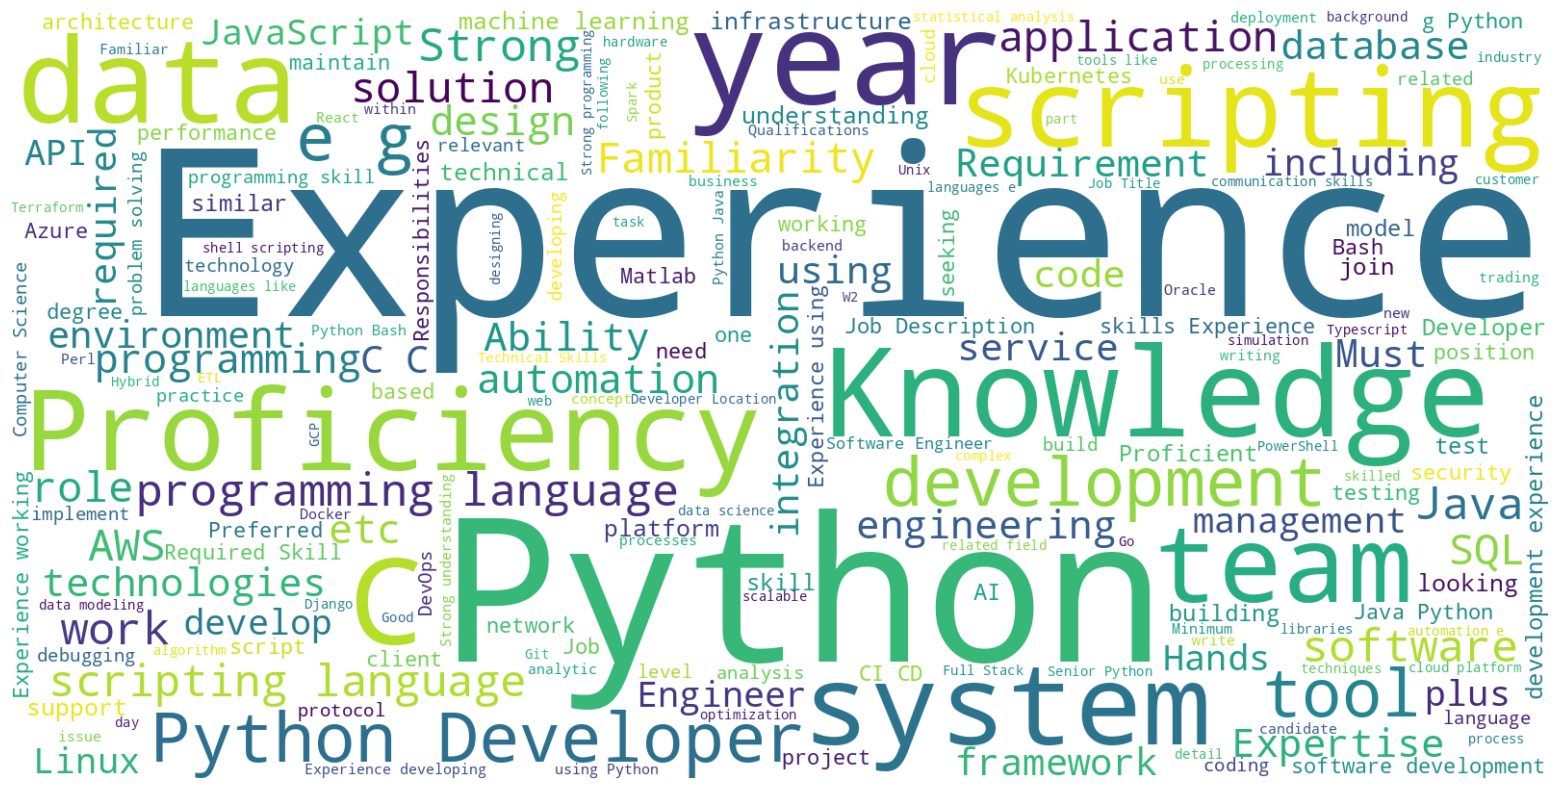

In [14]:
text = " ".join(df["description"])
wordcloud = WordCloud(width=1600, height=800, background_color="white", stopwords=stop_words).generate(text)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Аналіз біграм та триграм в описах вакансій

In [15]:
def get_ngrams(text_list: List[str], n: int) -> List[Tuple[str, ...]]:
    ngrams_list = []
    for text in text_list:
        tokens = text.split()
        ngrams_list += list(ngrams(tokens, n))
    return ngrams_list

num_ngrams = 15

bigrams = get_ngrams(df["description_cleaned"], 2)
trigrams = get_ngrams(df["description_cleaned"], 3)

bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

common_bigrams = bigram_freq.most_common(num_ngrams)
print(f"\nTop {num_ngrams} біграм:\n")
for gram, freq in common_bigrams:
    print(f'{" ".join(gram)}: {freq}')

common_trigrams = trigram_freq.most_common(num_ngrams)
print(f"\nTop {num_ngrams} триграм:\n")
for gram, freq in common_trigrams:
    print(f'{" ".join(gram)}: {freq}')


Top 15 біграм:

years experience: 137
python developer: 128
experience python: 98
scripting languages: 93
programming languages: 90
languages python: 77
machine learning: 61
java python: 58
skills experience: 58
development experience: 54
python experience: 51
software development: 49
c python: 49
eg python: 49
job description: 45

Top 15 триграм:

programming languages python: 37
proficiency programming languages: 32
scripting languages python: 28
scripting automation eg: 24
strong programming skills: 23
automation eg python: 22
degree computer science: 21
advanced sql skills: 21
senior python developer: 20
proficiency scripting languages: 20
experience scripting automation: 20
eg python advanced: 20
python advanced sql: 20
sql skills experience: 19
python developer location: 18


#### Аналіз рівня позицій у вакансіях

In [16]:
level_keywords = {
    "Junior": r"\b(?:junior|entry level|trainee|intern)\b",
    "Middle": r"\b(?:middle|mid-level|mid level|mid)\b",
    "Senior": r"\b(?:senior|sr|sr\.|experienced)\b",
    "Lead": r"\b(?:lead|team lead|principal|head|chief)\b",
}

def get_position_level(row: pd.Series) -> str:
    text = f"{row["title"]} {row["description"]}".lower()
    for level, pattern in level_keywords.items():
        if re.search(pattern, text):
            return level
    return "Not specified"

df["position_level"] = df.apply(get_position_level, axis=1)

level_counts = df["position_level"].value_counts().reset_index()
level_counts.columns = ["position_level", "vacancy_count"]

fig = px.pie(
    level_counts,
    names="position_level",
    values="vacancy_count",
    title="Розподіл вакансій за рівнем позиції",
    width=800,
    height=600.
)
fig.show()

#### Аналіз популярності технологій в описах вакансій

In [17]:
keywords = ["sql", "machine learning", "deep learning", "data science", "data analysis", "aws", "linux", "docker", "kubernetes", "django"]

for keyword in keywords:
    df[keyword] = df["description_cleaned"].str.contains(keyword, case=False).astype(int)

keyword_sums = df[keywords].sum()
keyword_df = pd.DataFrame(keyword_sums).reset_index()
keyword_df.columns = ["keyword", "count"]

fig = px.bar(
    keyword_df, 
    x="keyword", 
    y="count", 
    title="Популярність технологій в описах вакансій",
    labels={"keyword": "Технологія", "count": "Кількість згадувань"},
    width=1200,
    height=600,
)
fig.show()